# Example

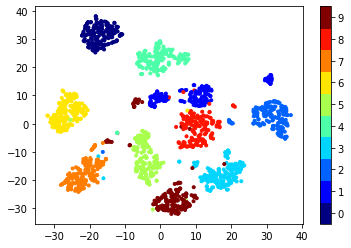

In [5]:
from sklearn.datasets import load_digits
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
%matplotlib inline

digits = load_digits()
embeddings = TSNE(n_jobs=4).fit_transform(digits.data)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=digits.target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

# 取出倒数第二层的结果

In [1]:
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

train_we = np.load('../Semantics/data/train_we_(32193, 120).npy')
test_we = np.load('../Semantics/data/test_we_(1613, 120).npy')
we_emb_matrix = np.load(
    '../Semantics/data/we_embedding_matrix_(6000, 300).npy')

y_fake_train = np.load('../dataset/data/train_label_(32193, 2).npy')
y_fake_test = np.load('../dataset/data/test_label_(1613, 2).npy')

train_we.shape, test_we.shape, y_fake_train.shape, y_fake_test.shape

((32193, 120), (1613, 120), (32193, 2), (1613, 2))

In [2]:
bigru_file = './model/BiGRU3.hdf5'
eann_file = './model/End2endBiGRU3.hdf5'
two_branches_imbalanced8_file = './model/Branches_Imbalanced8_BiGRU_TwoBranches.hdf5'
two_branches_balanced3_file = './model/Branches_Balanced3_BiGRU_TwoBranches5.hdf5'
two_branches_attention_file = './model/Branches_Balanced3_BiGRU_TwoBranches_attention2.hdf5'
branch_related = './model/Branches_Balanced3_BiGRU_SingleBranch_Related5.hdf5'
branch_unrelated = './model/Branches_Balanced3_BiGRU_SingleBranch_Unrelated5.hdf5'
branch_unrelated_imbalanced8 = './model/Branches_Imbalanced8_BiGRU_SingleBranch_Unrelated3.hdf5'

In [3]:
from keras import backend as K


def get_layer_output(model, x, index=-1):
    """
    get the computing result output of any layer you want, default the last layer.
    :param model: primary model
    :param x: input of primary model( x of model.predict([x])[0])
    :param index: index of target layer, i.e., layer[23]
    :return: result
    """
    layer = K.function([model.input], [model.layers[index].output])
    return layer([x])[0]

def get_train_test_prepredict(model, index):
    train_arr = get_layer_output(model, train_we, index)
    test_arr = get_layer_output(model, test_we, index)
    
    print('Pre-predict Dense of Train: ', train_arr.shape)
    print('Pre-predict Dense of Test: ', test_arr.shape)
    return train_arr, test_arr

def save_prepredict(model_name, train_arr, test_arr):
    np.save('./analysis/{}_train_{}.npy'.format(model_name, train_arr.shape), train_arr)
    np.save('./analysis/{}_test_{}.npy'.format(model_name, test_arr.shape), test_arr)

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/py

## BiGRU

In [4]:
from TextModels import BiGRU


model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix).model
model.load_weights(bigru_file)
model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 120, 64)      63936       embedding_1[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 64)           0  

In [5]:
train_arr, test_arr = get_train_test_prepredict(model)
save_prepredict('BiGRU', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 32)
Pre-predict Dense of Test:  (1613, 32)


## EANN

In [6]:
from TextTransferModels import End2endBiGRU


model = End2endBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix).model
model.load_weights(eann_file)
model.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 120, 64)      63936       embedding_2[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 64)           0           bidirectional_2[0][0]            
__________________________________________________________________________________________________
global_max

In [9]:
train_arr, test_arr = get_train_test_prepredict(model, index=-4)
save_prepredict('EANN', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 32)
Pre-predict Dense of Test:  (1613, 32)


## TwoBranches_Imbalanced8

In [6]:
from TextModels import BiGRU
from TextTransferModels import TwoBranchesBiGRU


related_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                      output=8, gradient_reversal=False).model
unrelated_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                        output=8, gradient_reversal=True).model

related_model.load_weights('./model/Branches_Imbalanced8_BiGRU_RelatedBranch_useClassWeight.hdf5')
unrelated_model.load_weights('./model/Branches_Imbalanced8_BiGRU_UnrelatedBranch_useClassWeight2.hdf5')

model = TwoBranchesBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                         related_branch_layer=related_model.get_layer('category_branch'),
                         unrelated_branch_layer=unrelated_model.get_layer('category_branch')).model

model.load_weights(two_branches_imbalanced8_file)
model.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 120, 64)      63936       embedding_6[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_6 (Glo (None, 64)           0           bidirectional_6[0][0]            
__________________________________________________________________________________________________
global_max

In [7]:
train_arr, test_arr = get_train_test_prepredict(model, index=-2)
save_prepredict('TwoBranches_Imbalanced8', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 64)
Pre-predict Dense of Test:  (1613, 64)


## TwoBranches_Balanced3

In [8]:
from TextModels import BiGRU
from TextTransferModels import TwoBranchesBiGRU

related_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                      output=3, gradient_reversal=False).model
unrelated_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                        output=3, gradient_reversal=True).model

related_model.load_weights('./model/Branches_Balanced3_BiGRU_RelatedBranch_useClassWeight.hdf5')
unrelated_model.load_weights('./model/Branches_Balanced3_BiGRU_UnrelatedBranch_useClassWeight.hdf5')

model = TwoBranchesBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                         related_branch_layer=related_model.get_layer('category_branch'),
                         unrelated_branch_layer=unrelated_model.get_layer('category_branch')).model

model.load_weights(two_branches_balanced3_file)
model.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 120, 64)      63936       embedding_9[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_9 (Glo (None, 64)           0           bidirectional_9[0][0]            
__________________________________________________________________________________________________
global_max

In [9]:
train_arr, test_arr = get_train_test_prepredict(model, index=-2)
save_prepredict('TwoBranches_Balanced3', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 64)
Pre-predict Dense of Test:  (1613, 64)


## TwoBranches_attention

In [10]:
from TextModels import BiGRU
from TextTransferModels import TwoBranchesBiGRU

related_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                      output=3, gradient_reversal=False).model
unrelated_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                        output=3, gradient_reversal=True).model

related_model.load_weights(
    './model/Branches_Balanced3_BiGRU_RelatedBranch_useClassWeight.hdf5')
unrelated_model.load_weights(
    './model/Branches_Balanced3_BiGRU_UnrelatedBranch_useClassWeight.hdf5')

model = TwoBranchesBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                         related_branch_layer=related_model.get_layer(
                             'category_branch'),
                         unrelated_branch_layer=unrelated_model.get_layer(
                             'category_branch'),
                         fusion_mode='attention').model

model.load_weights(two_branches_attention_file)
model.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 120, 64)      63936       embedding_12[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_12 (Gl (None, 64)           0           bidirectional_12[0][0]           
__________________________________________________________________________________________________
global_max

In [11]:
train_arr, test_arr = get_train_test_prepredict(model, index=-2)
save_prepredict('TwoBranches_attention', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 32)
Pre-predict Dense of Test:  (1613, 32)


## SingleBranch_Related

In [4]:
from TextModels import BiGRU
from TextTransferModels import TwoBranchesBiGRU

related_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                      output=3, gradient_reversal=False).model
unrelated_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                        output=3, gradient_reversal=True).model

related_model.load_weights(
    './model/Branches_Balanced3_BiGRU_RelatedBranch_useClassWeight.hdf5')
unrelated_model.load_weights(
    './model/Branches_Balanced3_BiGRU_UnrelatedBranch_useClassWeight.hdf5')

model = TwoBranchesBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                         related_branch_layer=related_model.get_layer(
                             'category_branch'),
                         unrelated_branch_layer=unrelated_model.get_layer(
                             'category_branch'),
                         use_unrelated_branch=False).model

model.load_weights(branch_related)
model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead





/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 120, 64)      63936       embedding_3[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 64)           0           bidirectional_3[0][0]            
__________________________________________________________________________________________________
global_max

In [5]:
train_arr, test_arr = get_train_test_prepredict(model, index=-2)
save_prepredict('SingleBranch_Related', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 32)
Pre-predict Dense of Test:  (1613, 32)


## SingleBranch_Unrelated

In [6]:
from TextModels import BiGRU
from TextTransferModels import TwoBranchesBiGRU

related_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                      output=3, gradient_reversal=False).model
unrelated_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                        output=3, gradient_reversal=True).model

related_model.load_weights(
    './model/Branches_Balanced3_BiGRU_RelatedBranch_useClassWeight.hdf5')
unrelated_model.load_weights(
    './model/Branches_Balanced3_BiGRU_UnrelatedBranch_useClassWeight.hdf5')

model = TwoBranchesBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                         related_branch_layer=related_model.get_layer(
                             'category_branch'),
                         unrelated_branch_layer=unrelated_model.get_layer(
                             'category_branch'),
                         use_related_branch=False).model

model.load_weights(branch_unrelated)
model.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 120, 64)      63936       embedding_6[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_6 (Glo (None, 64)           0           bidirectional_6[0][0]            
__________________________________________________________________________________________________
global_max

In [7]:
train_arr, test_arr = get_train_test_prepredict(model, index=-2)
save_prepredict('SingleBranch_Unrelated', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 32)
Pre-predict Dense of Test:  (1613, 32)


## SingleBranch_Unrelated_Imbalanced8

In [4]:
from TextModels import BiGRU
from TextTransferModels import TwoBranchesBiGRU

related_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                      output=8, gradient_reversal=False).model
unrelated_model = BiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                        output=8, gradient_reversal=True).model

related_model.load_weights(
    './model/Branches_Imbalanced8_BiGRU_RelatedBranch_useClassWeight.hdf5')
unrelated_model.load_weights(
    './model/Branches_Imbalanced8_BiGRU_UnrelatedBranch_useClassWeight2.hdf5')

model = TwoBranchesBiGRU(max_sequence_length=120, embedding_matrix=we_emb_matrix,
                         related_branch_layer=related_model.get_layer(
                             'category_branch'),
                         unrelated_branch_layer=unrelated_model.get_layer(
                             'category_branch'),
                         use_related_branch=False).model

model.load_weights(branch_unrelated_imbalanced8)
model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead





/usr/local/anaconda3/lib/python3.7/site-packages/keras/engine/topology.py:622: UserWarning: Class `GradientReversal.GradientReversal` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word2Vec (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 120, 300)     1800000     Word2Vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 120, 64)      63936       embedding_3[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 64)           0           bidirectional_3[0][0]            
__________________________________________________________________________________________________
global_max

In [5]:
train_arr, test_arr = get_train_test_prepredict(model, index=-2)
save_prepredict('SingleBranch_Unrelated_Imbalanced8', train_arr, test_arr)

Pre-predict Dense of Train:  (32193, 32)
Pre-predict Dense of Test:  (1613, 32)


# TSNE 可视化

In [1]:
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize

In [2]:
y_fake_train = np.load('../dataset/data/train_label_(32193, 2).npy')
y_fake_test = np.load('../dataset/data/test_label_(1613, 2).npy')
y_fake_train.shape, y_fake_test.shape

y_train = np.array([y.argmax() for y in y_fake_train])
y_test = np.array([y.argmax() for y in y_fake_test])
y_train.shape, y_test.shape

((32193,), (1613,))

In [3]:
def gen_tsne(train_arr_file, test_arr_file, SEED=0):
    train_arr = np.load(train_arr_file)
    test_arr = np.load(test_arr_file)
    print('train_arr: ', train_arr.shape)
    print('test_arr: ', test_arr.shape)
    print()

    train_tsne = TSNE(n_jobs=4).fit_transform(train_arr)
    test_tsne = TSNE(n_jobs=4).fit_transform(test_arr)
    print('train_tsne: ', train_tsne.shape)
    print('test_tsne: ', test_tsne.shape)
    return train_tsne, test_tsne


def save_tsne(train_tsne, test_tsne, model_name):
    np.save('./analysis/{}_train_tsne.npy'.format(model_name), train_tsne)
    np.save('./analysis/{}_test_tsne.npy'.format(model_name), test_tsne)


def load_tsne(model_name):
    return np.load('./analysis/{}_train_tsne.npy'.format(model_name)), np.load('./analysis/{}_test_tsne.npy'.format(model_name))


def show_rumor_nonrumor(X, y):
    sns.scatterplot(X[:, 0], X[:, 1], hue=y)


def show_source_target(train_tsne, test_tsne):
    sns.scatterplot(train_tsne[:, 0], train_tsne[:, 1], label='train')
    sns.scatterplot(test_tsne[:, 0], test_tsne[:, 1], label='test')


def load_norm_tsne(model_name):
    train_tsne, test_tsne = load_tsne(model_name)
    train_tsne_norm = normalize(train_tsne, axis=0, norm='max')
    test_tsne_norm = normalize(test_tsne, axis=0, norm='max')
    return train_tsne_norm, test_tsne_norm

## BiGRU

In [10]:
train_tsne, test_tsne = gen_tsne(
    './analysis/BiGRU_train_(32193, 32).npy', './analysis/BiGRU_test_(1613, 32).npy')

train_arr:  (32193, 32)
test_arr:  (1613, 32)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [12]:
save_tsne(train_tsne, test_tsne, 'BiGRU')

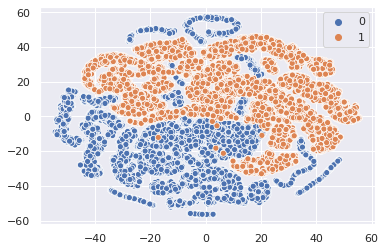

In [13]:
show_rumor_nonrumor(train_tsne, y_train)

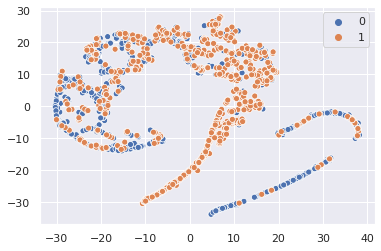

In [14]:
show_rumor_nonrumor(test_tsne, y_test)

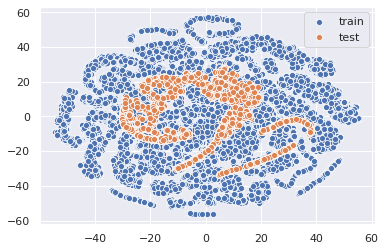

In [15]:
show_source_target(train_tsne, test_tsne)

## EANN

In [16]:
train_tsne, test_tsne = gen_tsne(
    './analysis/EANN_train_(32193, 32).npy', './analysis/EANN_test_(1613, 32).npy')

train_arr:  (32193, 32)
test_arr:  (1613, 32)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [17]:
save_tsne(train_tsne, test_tsne, 'EANN')

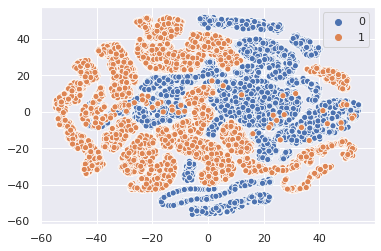

In [18]:
show_rumor_nonrumor(train_tsne, y_train)

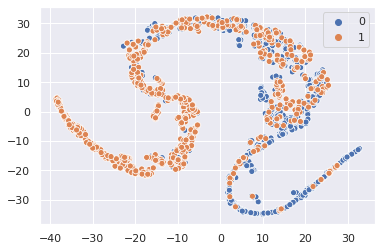

In [19]:
show_rumor_nonrumor(test_tsne, y_test)

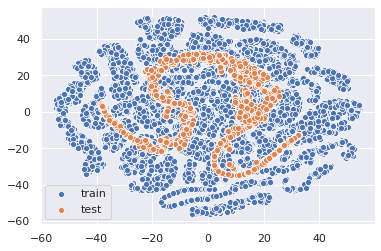

In [28]:
train_tsne, test_tsne = load_tsne('EANN')
show_source_target(train_tsne, test_tsne)

## TwoBranches_Imbalanced8

In [21]:
train_tsne, test_tsne = gen_tsne('./analysis/TwoBranches_Imbalanced8_train_(32193, 64).npy',
                                 './analysis/TwoBranches_Imbalanced8_test_(1613, 64).npy')

train_arr:  (32193, 64)
test_arr:  (1613, 64)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [22]:
save_tsne(train_tsne, test_tsne, 'TwoBranches_Imbalanced8')

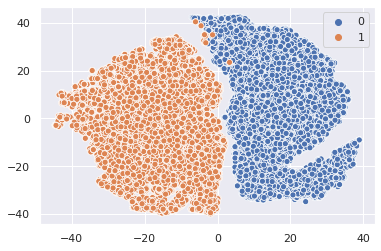

In [23]:
show_rumor_nonrumor(train_tsne, y_train)

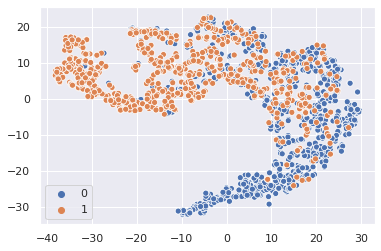

In [24]:
show_rumor_nonrumor(test_tsne, y_test)

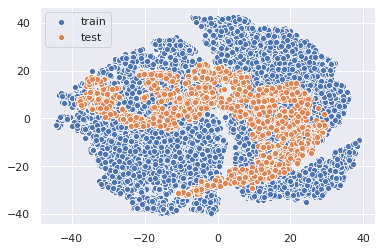

In [25]:
show_source_target(train_tsne, test_tsne)

## TwoBranches_Balanced3

In [26]:
train_tsne, test_tsne = gen_tsne('./analysis/TwoBranches_Balanced3_train_(32193, 64).npy',
                                 './analysis/TwoBranches_Balanced3_test_(1613, 64).npy')

train_arr:  (32193, 64)
test_arr:  (1613, 64)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [27]:
save_tsne(train_tsne, test_tsne, 'TwoBranches_Balanced3')

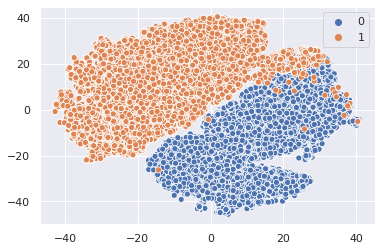

In [28]:
show_rumor_nonrumor(train_tsne, y_train)

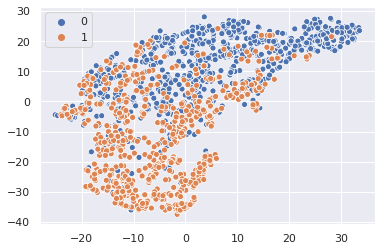

In [29]:
show_rumor_nonrumor(test_tsne, y_test)

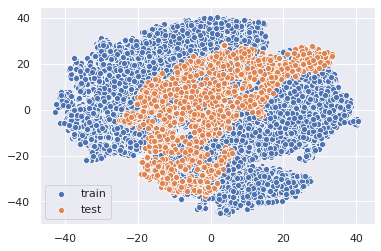

In [30]:
show_source_target(train_tsne, test_tsne)

## TwoBranches_attention

In [31]:
train_tsne, test_tsne = gen_tsne('./analysis/TwoBranches_attention_train_(32193, 32).npy',
                                 './analysis/TwoBranches_attention_test_(1613, 32).npy')

train_arr:  (32193, 32)
test_arr:  (1613, 32)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [32]:
save_tsne(train_tsne, test_tsne, 'TwoBranches_attention')

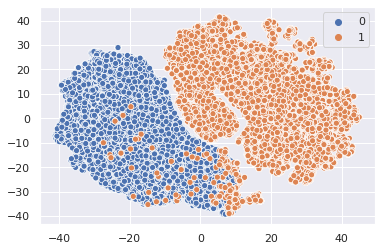

In [33]:
show_rumor_nonrumor(train_tsne, y_train)

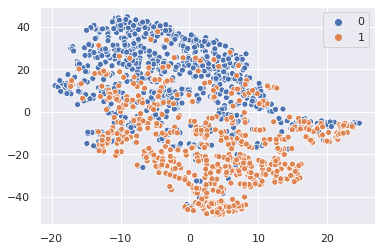

In [34]:
show_rumor_nonrumor(test_tsne, y_test)

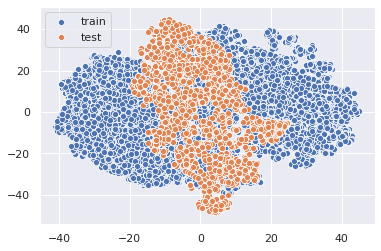

In [35]:
show_source_target(train_tsne, test_tsne)

## SingleBranch_Related

In [7]:
train_tsne, test_tsne = gen_tsne('./analysis/SingleBranch_Related_train_(32193, 32).npy',
                                 './analysis/SingleBranch_Related_test_(1613, 32).npy')

train_arr:  (32193, 32)
test_arr:  (1613, 32)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [8]:
save_tsne(train_tsne, test_tsne, 'SingleBranch_Related')

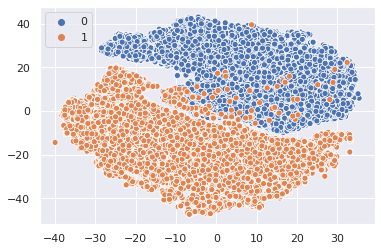

In [9]:
show_rumor_nonrumor(train_tsne, y_train)

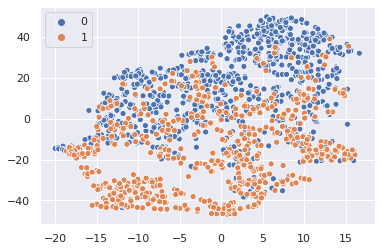

In [10]:
show_rumor_nonrumor(test_tsne, y_test)

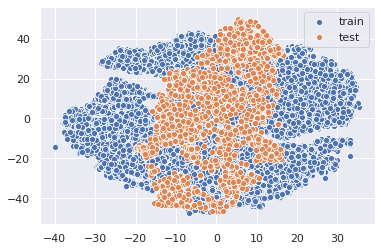

In [11]:
show_source_target(train_tsne, test_tsne)

## SingleBranch_Unrelated

In [12]:
train_tsne, test_tsne = gen_tsne('./analysis/SingleBranch_Unrelated_train_(32193, 32).npy',
                                 './analysis/SingleBranch_Unrelated_test_(1613, 32).npy')

train_arr:  (32193, 32)
test_arr:  (1613, 32)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [13]:
save_tsne(train_tsne, test_tsne, 'SingleBranch_Unrelated')

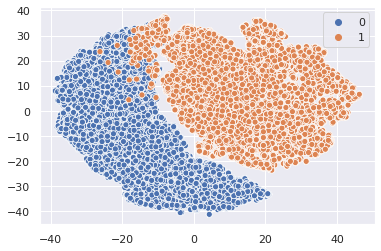

In [14]:
show_rumor_nonrumor(train_tsne, y_train)

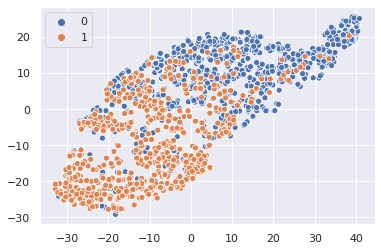

In [15]:
show_rumor_nonrumor(test_tsne, y_test)

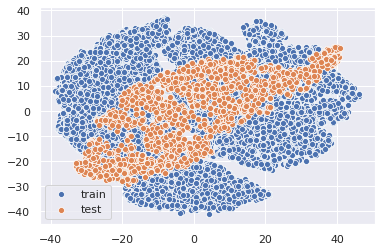

In [16]:
show_source_target(train_tsne, test_tsne)

## SingleBranch_Unrelated_Imbalanced8

In [4]:
train_tsne, test_tsne = gen_tsne('./analysis/SingleBranch_Unrelated_Imbalanced8_train_(32193, 32).npy',
                                 './analysis/SingleBranch_Unrelated_Imbalanced8_test_(1613, 32).npy')

train_arr:  (32193, 32)
test_arr:  (1613, 32)

train_tsne:  (32193, 2)
test_tsne:  (1613, 2)


In [5]:
save_tsne(train_tsne, test_tsne, 'SingleBranch_Unrelated_Imbalanced8')

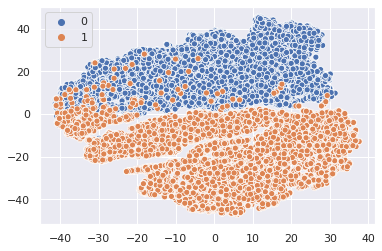

In [6]:
show_rumor_nonrumor(train_tsne, y_train)

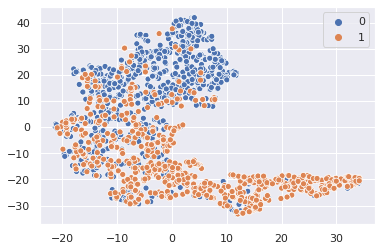

In [7]:
show_rumor_nonrumor(test_tsne, y_test)

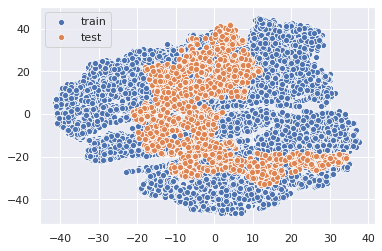

In [8]:
show_source_target(train_tsne, test_tsne)

## 对比

### Source & Target

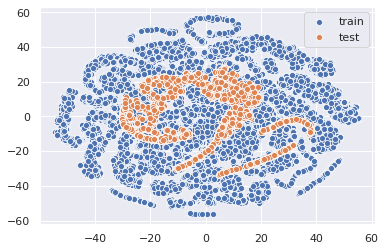

In [4]:
train_tsne, test_tsne = load_tsne('BiGRU')
show_source_target(train_tsne, test_tsne)

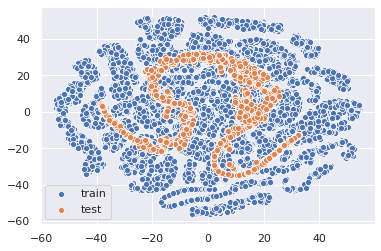

In [5]:
train_tsne, test_tsne = load_tsne('EANN')
show_source_target(train_tsne, test_tsne)

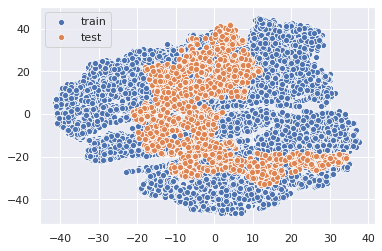

In [9]:
train_tsne, test_tsne = load_tsne('SingleBranch_Unrelated_Imbalanced8')
show_source_target(train_tsne, test_tsne)

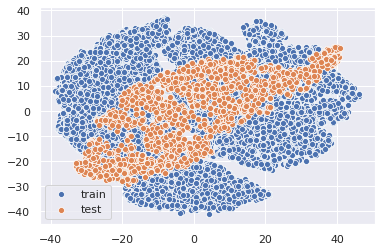

In [6]:
train_tsne, test_tsne = load_tsne('SingleBranch_Unrelated')
show_source_target(train_tsne, test_tsne)

### Rumor & Non-Rumor

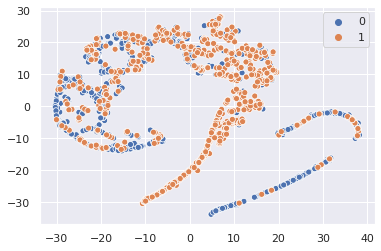

In [7]:
train_tsne, test_tsne = load_tsne('BiGRU')
show_rumor_nonrumor(test_tsne, y_test)

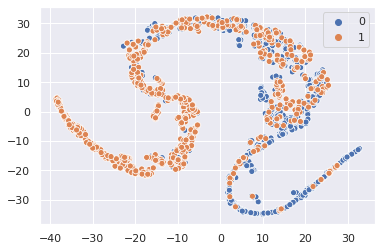

In [8]:
train_tsne, test_tsne = load_tsne('EANN')
show_rumor_nonrumor(test_tsne, y_test)

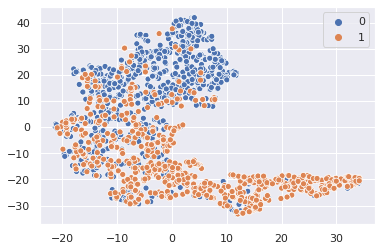

In [10]:
train_tsne, test_tsne = load_tsne('SingleBranch_Unrelated_Imbalanced8')
show_rumor_nonrumor(test_tsne, y_test)

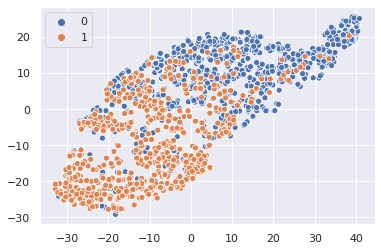

In [9]:
train_tsne, test_tsne = load_tsne('SingleBranch_Unrelated')
show_rumor_nonrumor(test_tsne, y_test)